In [45]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [46]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())
#device = torch.device("cpu")

# Close all open plots
plt.close('all')

True


In [47]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_2.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_2.mat')
data_out = scipy.io.loadmat(filepath)


# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size
print(buildtot)


[[0.17562743]
 [0.17571144]
 [0.17559742]
 ...
 [0.21935459]
 [0.22091489]
 [0.22091489]]


In [48]:
# Create time vector
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 3)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 2

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        )    
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [49]:

# Set number of epochs
epochs = 300

# Set dimensions for LSTM layers
idd = 3
odd = yExp[0, 0].shape[1]

# Initialize variable to track the smallest loss
best_loss = float('inf')
best_hdd_ldd = None  # To track which hdd, ldd combination gives the best loss
i=0
final_loss = torch.zeros(8)

for hdd in [150]: 
    for ldd in [1]:
        print(f"Training LSTM with hdd={hdd} and ldd={ldd}")
        
        # Initialize RNN model
        LTS = LSTModel(idd, hdd, ldd, odd)
        
        # Define loss function
        MSE = nn.MSELoss()

        # Define optimization method
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
        optimizer.zero_grad()

        # Initialize array to store loss values
        LOSS = np.zeros(epochs)

        # Train the RNN model
        for epoch in range(epochs):
            # Adjust learning rate at certain epochs
            if epoch == epochs - epochs // 2:
                learning_rate = 1.0e-3
                optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
            if epoch == epochs - epochs // 6:
                learning_rate = 1.0e-4
                optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
            
            optimizer.zero_grad()

            # Get LSTM output for training data
            yLTS = LTS(u)
            yLTS = torch.squeeze(yLTS)

            # Calculate loss and backpropagate
            loss = MSE(yLTS[:,10:,:], y[:,10:,:])
            loss.backward()
            optimizer.step()

            # Print loss for the current epoch
            #print(f"Epoch: {epoch + 1} \t||\t Loss: {loss.item()}")
            LOSS[epoch] = loss.item()


          
        final_loss[i] = LOSS[-1]  # Loss at the last epoch
        if final_loss[i] < best_loss:
            best_loss = final_loss[i]
            best_hdd_ldd = (hdd, ldd)
            saved_loss = LOSS
            # Save the model parameters with the lowest validation loss
            torch.save(LTS.state_dict(), 'best_LTS_Q.pth')
            print(f"Best model so far saved with hdd={hdd}, ldd={ldd} and loss={best_loss}")
        i += 1  
print(f"Training completed. Best model was with hdd={best_hdd_ldd[0]}, ldd={best_hdd_ldd[1]} and loss={best_loss}")

"""# validation part to add if needed...
       
        # Check if this model has the smallest loss
        final_loss[i] = loss_val  # Loss at the last epoch
        if final_loss[i] < best_loss:
            best_loss = final_loss[i]
            best_hdd_ldd = (hdd, ldd)
            saved_loss = LOSS"""

Training LSTM with hdd=150 and ldd=1
Best model so far saved with hdd=150, ldd=1 and loss=0.001541217672638595
Training completed. Best model was with hdd=150, ldd=1 and loss=0.001541217672638595


'# validation part to add if needed...\n       \n        # Check if this model has the smallest loss\n        final_loss[i] = loss_val  # Loss at the last epoch\n        if final_loss[i] < best_loss:\n            best_loss = final_loss[i]\n            best_hdd_ldd = (hdd, ldd)\n            saved_loss = LOSS'

In [50]:
#validation part
nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval = torch.zeros(nExp, t_end, 3)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
            (torch.from_numpy(dExp_val[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        ) 
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))

# Get RNN output for validation data
yLTS_val = LTS(uval)

# Calculate loss for validation data
loss_val = MSE(yLTS_val[:,:,:], yval[:,:,:])

tensor([0.0015, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
(150, 1)


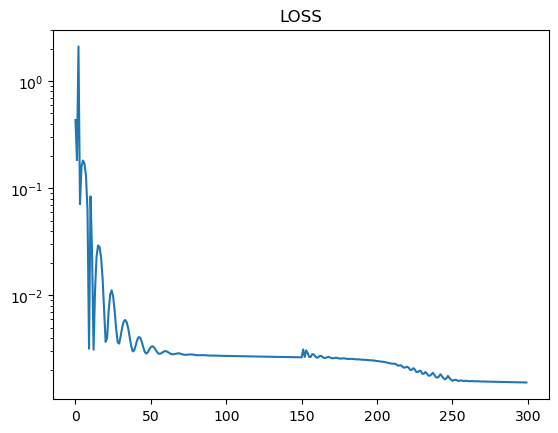

In [51]:
print(final_loss)
print(best_hdd_ldd)

# Plot loss over epochs
plt.figure('8')
plt.semilogy(saved_loss)
plt.title("LOSS")
plt.show()


In [52]:

"""#Set dimensions for RNN layers
idd = u[0,:,:].shape[1] #3
hdd = 150 #7 /10
ldd = 1 #2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
LTS = LSTModel(idd, hdd, ldd, odd)

# Load the model parameters before starting a new training session
#LTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 5.0e-3
optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 300

# Initialize array to store loss values
LOSS = np.zeros(epochs)"""


"#Set dimensions for RNN layers\nidd = u[0,:,:].shape[1] #3\nhdd = 150 #7 /10\nldd = 1 #2\nodd = yExp[0, 0].shape[1]\n\n# Initialize RNN model\nLTS = LSTModel(idd, hdd, ldd, odd)\n\n# Load the model parameters before starting a new training session\n#LTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))\n\n# Define loss function\nMSE = nn.MSELoss()\n\n# Define optimization method\nlearning_rate = 5.0e-3\noptimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)\noptimizer.zero_grad()\n\n# Set number of epochs\nepochs = 300\n\n# Initialize array to store loss values\nLOSS = np.zeros(epochs)"

In [53]:

"""# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yLTS = LTS(u)
    yLTS = torch.squeeze(yLTS)
    

    # Calculate loss and backpropagate
    loss = MSE(yLTS[:,:,:], y[:,:,:])
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(LTS.state_dict(), f'parameters_LSTM_direct.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")
"""

'# Train the RNN model\nfor epoch in range(epochs):\n    # Adjust learning rate at certain epochs\n    if epoch == epochs - epochs / 2:\n        learning_rate = 1.0e-3\n        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)\n    if epoch == epochs - epochs / 6:\n        learning_rate = 1.0e-4\n        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)\n    optimizer.zero_grad()\n    loss = 0\n\n    # Get RNN output for training data\n    yLTS = LTS(u)\n    yLTS = torch.squeeze(yLTS)\n    \n\n    # Calculate loss and backpropagate\n    loss = MSE(yLTS[:,:,:], y[:,:,:])\n    loss.backward()\n    optimizer.step()\n    \n\n    # Print loss for current epoch\n    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")\n    LOSS[epoch] = loss\n    \n    # Save model parameters every 15 epochs\n    if (epoch + 1) % 15 == 0:\n        torch.save(LTS.state_dict(), f\'parameters_LSTM_direct.pth\')\n        print(f"Model parameters saved at epoch {epoch + 1}")\n'

In [54]:
"""# Initialize RNN model
#LTS = LSTModel(idd, best_hdd_ldd[0], best_hdd_ldd[1], odd)
#LTS = LSTModel(idd, 10, 2, odd)
# Load the model parameters before starting a new training session
#LTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))
yLTS = LTS(u)
yLTS = torch.squeeze(yLTS)

##################validation#####################
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 3)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        ) 
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yLTS_val = LTS(uval)
#yLTS_val = yLTS_val.unsqueeze_(0)
print(uval)
# Calculate loss for validation data
loss_val = MSE(yLTS_val[:,:,:], yval[:,:,:])"""

"# Initialize RNN model\n#LTS = LSTModel(idd, best_hdd_ldd[0], best_hdd_ldd[1], odd)\n#LTS = LSTModel(idd, 10, 2, odd)\n# Load the model parameters before starting a new training session\n#LTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))\nyLTS = LTS(u)\nyLTS = torch.squeeze(yLTS)\n\n##################validation#####################\n# Initialize input and output tensors for validation data\nnExp = yExp_val.size\nuval = torch.zeros(nExp, t_end, 3)\nyval = torch.zeros(nExp, t_end, 2)\n\n# Fill input and output tensors with validation data\nfor j in range(nExp):\n    uval[j, :, :] = torch.cat(\n            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp\n            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot\n            dim=-1\n        ) \n    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))\n    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))\n

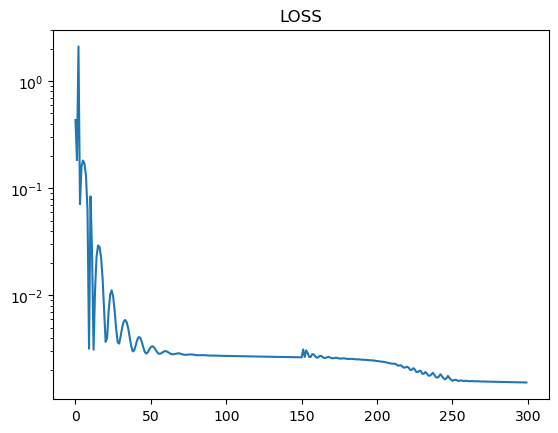

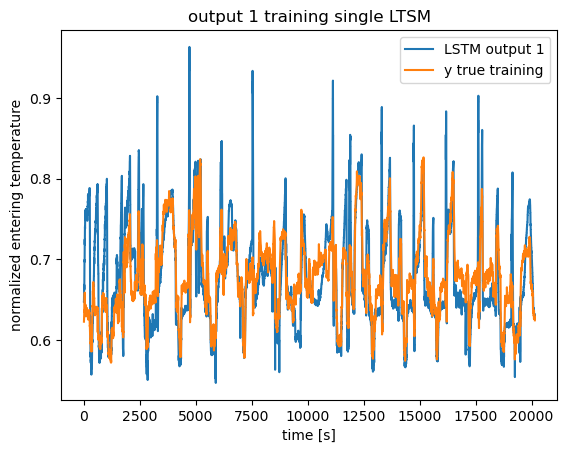

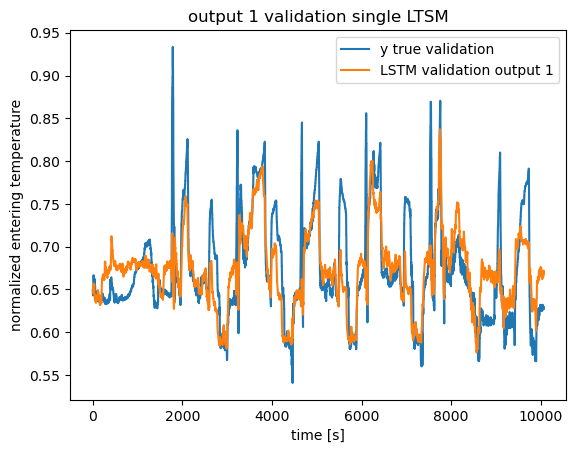

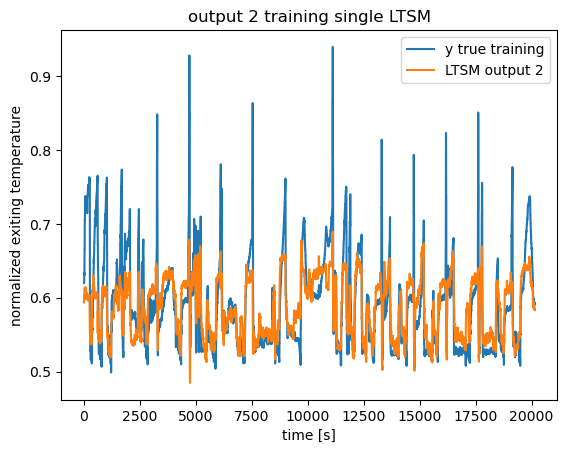

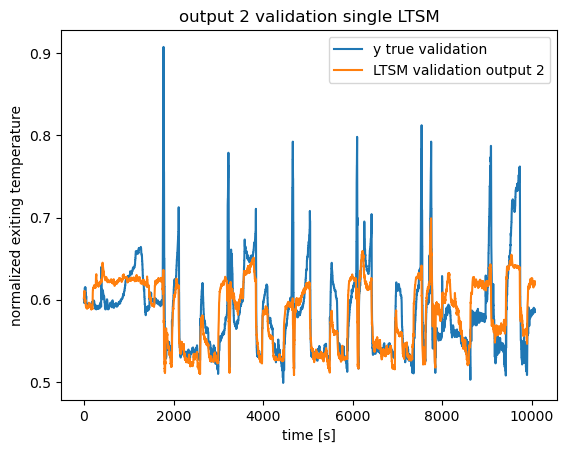

Loss Validation single LTSM: 0.0015157856978476048


In [55]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.yscale('log')
plt.show()
   
# Plot output 1 for training data
plt.figure('9')
plt.plot(y[0, 10:, 0].detach().numpy(), label='LSTM output 1')
plt.plot(yLTS[0, 10:, 0].detach().numpy(), label='y true training')
plt.title("output 1 training single LTSM")
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("normalized entering temperature")
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y true validation')
plt.plot(yLTS_val[0, 10:, 0].detach().numpy(), label='LSTM validation output 1')
plt.title("output 1 validation single LTSM")
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("normalized entering temperature")
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(y[0, 10:, 1].detach().numpy(), label='y true training')
plt.plot(yLTS[0, 10:, 1].detach().numpy(), label='LTSM output 2')
plt.title("output 2 training single LTSM")
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("normalized exiting temperature")
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yval[0, 10:, 1].detach().numpy(), label='y true validation')
plt.plot(yLTS_val[0,10:, 1].detach().numpy(), label='LTSM validation output 2')
plt.title("output 2 validation single LTSM")
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("normalized exiting temperature")
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID_LTSM.mat', dict(yLTSm_val=yLTS_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single LTSM: {loss_val}")

In [56]:
print(yLTS.shape)
print(yLTS_val.shape)

torch.Size([6, 20160, 2])
torch.Size([1, 10080, 2])


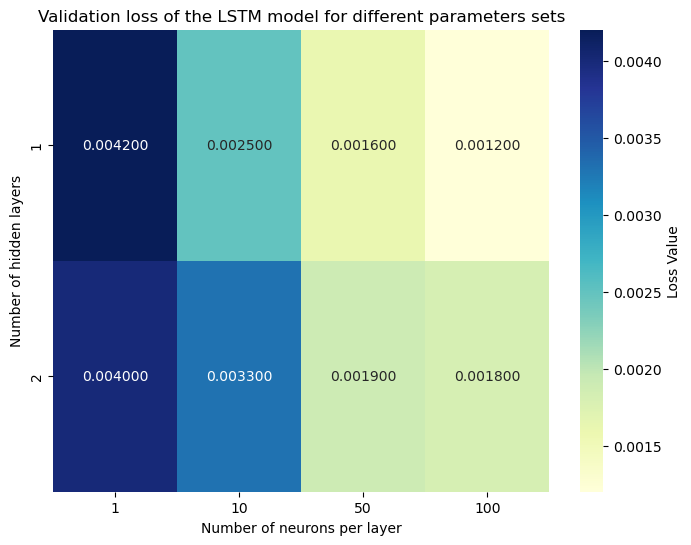

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Data for neurons, layers, and loss values
data = {
    "neurons": [1, 10, 50, 100, 1, 10, 50, 100 ],
    "layers": [1, 1, 1, 1, 2, 2, 2, 2],
    "loss" : [0.0042, 0.0025, 0.0016, 0.0012,
                0.0040, 0.0033, 0.0019, 0.0018]
}
#"loss": [0.0035908, 0.0046,0.0051, 0.0052,
             #0.0031279, 0.0034, 0.0049, 0.0048]
             
# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot the data for heatmap
pivot_table = df.pivot(index="layers", columns="neurons", values="loss")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Loss Value'}, fmt=".6f")
plt.title("Validation loss of the LSTM model for different parameters sets")
plt.xlabel("Number of neurons per layer")
plt.ylabel("Number of hidden layers")
plt.show()
